<h1><center>18CSC412    
<h1><center>Deep Learning for NLP

#Team members:     


####Dheer Shaji      : CB.SC.I5DAS18007     
####Vaishnavi R Nath : CB.SC.I5DAS18038

<h1><center>RESUME PARSER USING NATURAL LANGUAGE PROCESSING TECHNIQUES</center></h1>
<h1><center> Final Review


####Importing necessary packages and libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from wordcloud import WordCloud
from num2words import num2words

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [171]:
!pip install gensim

In [ ]:
nltk.download('stopwords')

In [172]:
import gensim

In [77]:
!pip install num2words

#### Mounting drive and data import

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [66]:
df=pd.read_csv("/content/drive/MyDrive/NLP/UpdatedResumeDataSet.csv")
df.head(5)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [67]:
df1=pd.read_csv("/content/drive/MyDrive/NLP/resume_dataset.csv")
df1.head()

,ID,Category,Resume
0,1,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box..."
1,2,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...
2,3,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...
3,4,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...
4,5,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert..."


In [68]:
df1.drop(['ID'], axis=1,inplace=True)
df1.head(5)

,Category,Resume
0,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box..."
1,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...
2,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...
3,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...
4,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert..."


####Data Concatenation

In [69]:
df=pd.concat([df, df1], ignore_index = True)

In [70]:
df.shape

(2181, 2)

In [71]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing',
       'Designing', 'Managment', 'Information Technology', 'Education',
       'Business Development', 'Health & Fitness', 'Agricultural', 'BPO',
       'Consultant', 'Digital Media', 'Automobile', 'Food & Beverages',
       'Finance', 'Apparel', 'Engineering', 'Accountant',
       'Building & Construction', 'Architects', 'Public Relations',
       'Banking', 'Aviation'], dtype=object)

In [72]:
business = ['HR','Sales','Business Analyst','Business Development','Public Relations','Managment','BPO','Public Relations','PMO','Consultant','Operations Manager']
designing = ['Web Designing','Designing','Digital Media','Arts']
civil_engineering = ['Civil Engineer','Building & Construction','Architects']
engineering = ['Mechanical Engineer','Engineering','Automobile']
banking = ['Banking','Finance','Accountant','Blockchain']
health = ['Health & Fitness','Health and fitness','Food & Beverages']
it = ['Hadoop','DataBase','Information Technology','Network Security Engineer','DevOps Engineer','Java Developer','SAP Developer','Python Developer', 'ETL Developer','DotNet Developer','Automation Testing','Testing']

In [73]:
df['Category']=df['Category'].replace(to_replace =business, value ="Business")
df['Category']=df['Category'].replace(to_replace =civil_engineering, value ="Civil Engineering")
df['Category']=df['Category'].replace(to_replace =engineering, value ="Mechanical Engineering")
df['Category']=df['Category'].replace(to_replace =banking, value ="Banking")
df['Category']=df['Category'].replace(to_replace =it, value ="IT")
df['Category']=df['Category'].replace(to_replace =health, value ="Health&Fitness")
df['Category']=df['Category'].replace(to_replace =designing, value ="Designing")

####Data Visualization

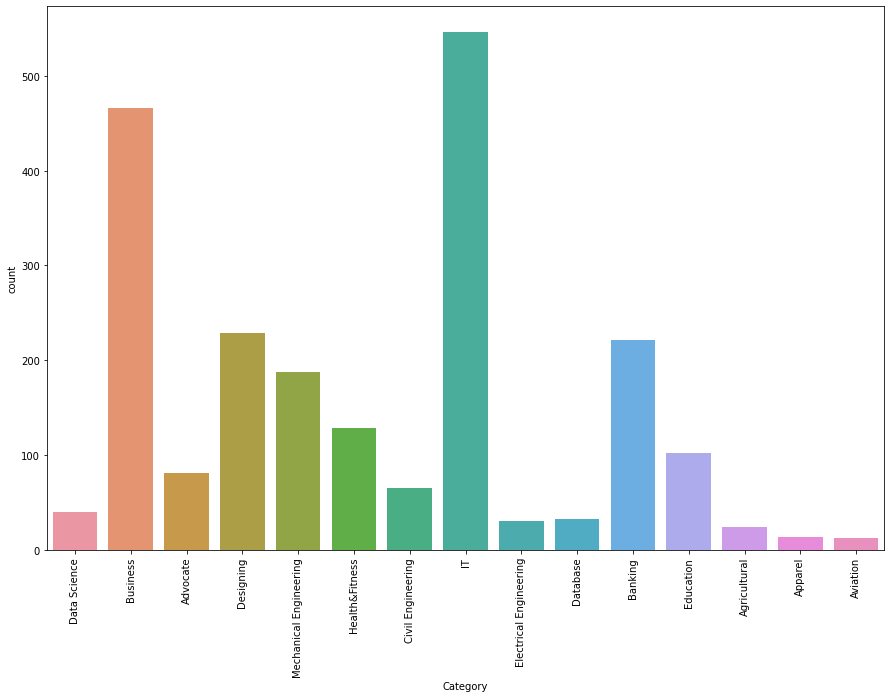

In [74]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.countplot(x = "Category", data = df)

#### Text Preprocessing

Removing useless symbols and characters

In [75]:
def cleanResume(resumeText):
    resumeText = re.sub('httpS+s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^x00-x7f]',r' ', resumeText)  # remove non ascii values
    resumeText = re.sub(r'[/\r/\n]',r' ', resumeText)
    resumeText = re.sub('s+', ' ', resumeText)  # remove extra whitespace
    return resumeText
df['cleaned_resume'] = df.Resume.apply(lambda x: cleanResume(x))

In [76]:
df.head(5)

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,Skill Programming Language P thon panda ...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Detail Ma 2013 to Ma 2017 B E ...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Area of Intere t Deep Learning Control S te...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skill R P thon SAP HANA Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Detail MCA YMCAUST Faridabad...


Converting numerical values to its corresponding word representation

In [78]:
def num_to_word(text):
  after_split = text.split()
  for idx in range(len(after_split)):
    if after_split[idx].isdigit():
      after_split[idx] = num2words(after_split[idx])
  nums_to_words = ' '.join(after_split)
  return nums_to_words

In [79]:
df["cleaned_resume"]=df["cleaned_resume"].apply(num_to_word)
df.head()

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,Skill Programming Language P thon panda nump c...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Detail Ma two thousand and thirteen ...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Area of Intere t Deep Learning Control S tem D...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skill R P thon SAP HANA Tableau SAP HANA SQL S...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Detail MCA YMCAUST Faridabad Har ana...


Convert all characters to lower case

In [80]:
def lower_case_conversion(text):
  lower_text=text.lower()
  return lower_text

df["cleaned_resume"]=df["cleaned_resume"].apply(lower_case_conversion)
df.head()

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language p thon panda nump c...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail ma two thousand and thirteen ...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area of intere t deep learning control s tem d...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r p thon sap hana tableau sap hana sql s...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad har ana...


Stopwords removal

In [82]:
stop = stopwords.words('english')
df['cleaned_resume'] = df['cleaned_resume'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [83]:
df.head(5)

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language p thon panda nump c...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail two thousand thirteen two tho...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area intere deep learning control tem de ign p...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r p thon sap hana tableau sap hana sql s...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad har ana...


#### Encoding categorical attributes

In [85]:
var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [86]:
df.head()

,Category,Resume,cleaned_resume
0,7,Skills * Programming Languages: Python (pandas...,skill programming language p thon panda nump c...
1,7,Education Details \r\nMay 2013 to May 2017 B.E...,education detail two thousand thirteen two tho...
2,7,"Areas of Interest Deep Learning, Control Syste...",area intere deep learning control tem de ign p...
3,7,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r p thon sap hana tableau sap hana sql s...
4,7,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad har ana...


#### Vectorizer
Map words or phrases from vocabulary to a corresponding vector of real numbers

In [87]:
requiredText = df['cleaned_resume'].values
requiredTarget = df['Category'].values
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

####TrainTest Split

In [25]:
X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=0, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(1744, 1500)
(437, 1500)


#### Machine Learning Models

##### OneVsRestClassifier

In [57]:
ovr= OneVsRestClassifier(KNeighborsClassifier())
ovr.fit(X_train,y_train)
y_pred_ovr = ovr.predict(X_test)
print('Accuracy:', accuracy_score(y_pred_ovr, y_test))
print('Precision:', precision_score(y_test, y_pred_ovr, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_ovr, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred_ovr, average='weighted'))

Accuracy: 0.5560640732265446
Precision: 0.7569883157582015
Recall: 0.5560640732265446
F1 Score: 0.6038062231272036


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#####Logistic Regression

In [46]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train,y_train)
y_pred_logistic = model_logistic.predict(X_test)
print('Accuracy:', accuracy_score(y_pred_logistic, y_test))
print('Precision:', precision_score(y_test, y_pred_logistic, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_logistic, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred_logistic, average='weighted'))

Accuracy: 0.8215102974828375
Precision: 0.8304124049548218
Recall: 0.8215102974828375
F1 Score: 0.8130266764882906


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### RandomForestClassifier

In [47]:
rf_c = RandomForestClassifier()
rf_c.fit(X_train,y_train)
y_pred_rfc = rf_c.predict(X_test)
print('Accuracy:', accuracy_score(y_pred_rfc, y_test))
print('Precision:', precision_score(y_test, y_pred_rfc, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_rfc, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred_rfc, average='weighted'))

Accuracy: 0.8398169336384439
Precision: 0.8449353017571493
Recall: 0.8398169336384439
F1 Score: 0.8339269840764703


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Support Vector Classifier

In [48]:
svc = SVC(kernel = "rbf")
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
print('Accuracy:', accuracy_score(y_pred_svc, y_test))
print('Precision:', precision_score(y_test, y_pred_svc, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_svc, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred_svc, average='weighted'))

Accuracy: 0.8489702517162472
Precision: 0.862743793289047
Recall: 0.8489702517162472
F1 Score: 0.8439742506944669


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### LightGBM

In [50]:
lgbm= lgb.LGBMClassifier()
lgbm.fit(X_train,y_train)
y_pred_lgb = lgbm.predict(X_test)
print('Accuracy:', accuracy_score(y_pred_lgb, y_test))
print('Precision:', precision_score(y_test, y_pred_lgb, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_lgb, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred_lgb, average='weighted'))

Accuracy: 0.8604118993135011
Precision: 0.8566651725784862
Recall: 0.8604118993135011
F1 Score: 0.8564152284929899


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Deep Learning Models

Tfidf Vectorizer

In [90]:
vec = TfidfVectorizer()
x_tf = vec.fit_transform(df.Resume)
x_tf.shape

(2181, 61756)

Defining X values

In [93]:
X = df.cleaned_resume
X.head()

0    skill programming language p thon panda nump c...
1    education detail two thousand thirteen two tho...
2    area intere deep learning control tem de ign p...
3    skill r p thon sap hana tableau sap hana sql s...
4    education detail mca ymcaust faridabad har ana...
Name: cleaned_resume, dtype: object

Encoding y values

In [94]:
one_encoder =  OneHotEncoder()
y_onehot = one_encoder.fit_transform(df.Category.values.reshape(-1,1)).toarray()
y_onehot[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [98]:
max_words = 3000

X_train,X_test,y_train,y_test = train_test_split(X,y_onehot,random_state=0,test_size=0.20)

token = Tokenizer(num_words = max_words,oov_token="<OOV>")
token.fit_on_texts(X_train.values)
X_train = token.texts_to_sequences(X_train.values)
X_test =  token.texts_to_sequences(X_test.values)

In [99]:
len(token.word_index)

45108

 To ensure that all sequences in a list have the same length, pad sequence is applied

In [100]:
max_length = 600
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test,max_length,padding = "post")

In [101]:
vocab_size = len(token.word_index) + 1

##### Model 1

In [109]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 600, 100)          4510900   
                                                                 
 conv1d_1 (Conv1D)           (None, 596, 32)           16032     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 298, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9536)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1220736   
                                                                 
 dense_3 (Dense)             (None, 15)                1935      
                                                      

In [110]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [115]:
history = model.fit(X_train,y_train,epochs=50,batch_size=16,callbacks = [callback])

Epoch 1/50
109/109 [==============================] - 7s 61ms/step - loss: 0.1083 - accuracy: 0.9759
Epoch 2/50
109/109 [==============================] - 7s 60ms/step - loss: 0.0973 - accuracy: 0.9736
Epoch 3/50
109/109 [==============================] - 7s 61ms/step - loss: 0.0892 - accuracy: 0.9753
Epoch 4/50
109/109 [==============================] - 6s 59ms/step - loss: 0.0825 - accuracy: 0.9748
Epoch 5/50
109/109 [==============================] - 8s 77ms/step - loss: 0.0696 - accuracy: 0.9759
Epoch 6/50
109/109 [==============================] - 8s 78ms/step - loss: 0.0632 - accuracy: 0.9725
Epoch 7/50
109/109 [==============================] - 9s 87ms/step - loss: 0.0630 - accuracy: 0.9753
Epoch 8/50
109/109 [==============================] - 6s 59ms/step - loss: 0.0587 - accuracy: 0.9759
Epoch 9/50
109/109 [==============================] - 7s 64ms/step - loss: 0.0547 - accuracy: 0.9742
Epoch 10/50
109/109 [==============================] - 6s 59ms/step - loss: 0.0557 - accura

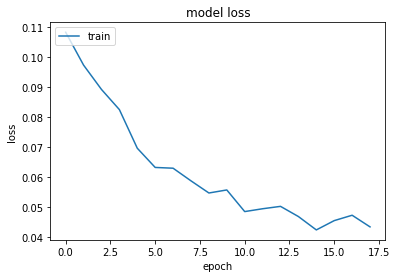

In [116]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [117]:
model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 16ms/step - loss: 1.0146 - accuracy: 0.7437


[1.0146287679672241, 0.7437071204185486]

##### model 2

In [162]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(5))
#model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='softmax'))
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 600, 100)          4510900   
                                                                 
 flatten_12 (Flatten)        (None, 60000)             0         
                                                                 
 dropout_7 (Dropout)         (None, 60000)             0         
                                                                 
 dense_27 (Dense)            (None, 5)                 300005    
                                                                 
 dropout_8 (Dropout)         (None, 5)                 0         
                                                                 
 flatten_13 (Flatten)        (None, 5)                 0         
                                                                 
 dense_28 (Dense)            (None, 128)             

In [163]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [166]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [167]:
history = model.fit(X_train,y_train,epochs=50,batch_size=16,callbacks = [callback])

Epoch 1/50
109/109 [==============================] - 5s 40ms/step - loss: 2.3145 - accuracy: 0.2443
Epoch 2/50
109/109 [==============================] - 4s 40ms/step - loss: 1.8255 - accuracy: 0.3807
Epoch 3/50
109/109 [==============================] - 4s 41ms/step - loss: 1.4967 - accuracy: 0.4708
Epoch 4/50
109/109 [==============================] - 4s 41ms/step - loss: 1.2342 - accuracy: 0.5596
Epoch 5/50
109/109 [==============================] - 4s 40ms/step - loss: 1.0945 - accuracy: 0.6078
Epoch 6/50
109/109 [==============================] - 4s 41ms/step - loss: 1.0257 - accuracy: 0.6239
Epoch 7/50
109/109 [==============================] - 4s 41ms/step - loss: 0.9771 - accuracy: 0.6319
Epoch 8/50
109/109 [==============================] - 4s 40ms/step - loss: 0.9506 - accuracy: 0.6508
Epoch 9/50
109/109 [==============================] - 4s 40ms/step - loss: 0.8683 - accuracy: 0.6886
Epoch 10/50
109/109 [==============================] - 4s 40ms/step - loss: 0.9001 - accura

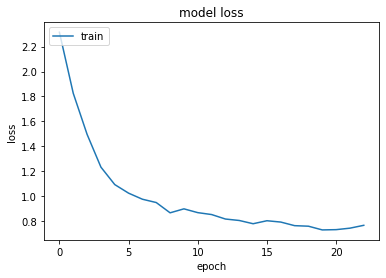

In [168]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [169]:
model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 5ms/step - loss: 1.0526 - accuracy: 0.7117


[1.0526167154312134, 0.711670458316803]

##### Model 3

In [173]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

In [176]:
# build vocabulary
model.build_vocab(df.cleaned_resume, progress_per=1000)

In [177]:
#training word2vec model
model.train(df.cleaned_resume, total_examples=model.corpus_count, epochs=model.epochs)

(9898520, 51561560)

In [179]:
# total numberof extracted words.
vocab=model.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  40


In [181]:
vocab=list(vocab.keys())

In [183]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict))

The no of key-value pairs :  40
